In [81]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

import tqdm 
from tqdm import tqdm

In [82]:
# Leaky neuron model, overriding the backward pass with a custom function
class LeakySurrogate(nn.Module):
    def __init__(self, beta, threshold=1.0):
        super(LeakySurrogate, self).__init__()

        # initialize decay rate beta and threshold
        self.beta = beta
        self.threshold = threshold
        self.spike_gradient = self.ATan.apply

    # the forward function is called each time we call Leaky
    def forward(self, input_, mem):
        spk   = self.spike_gradient((mem - self.threshold))     # call the Heaviside function
        reset = (self.beta * spk * self.threshold).detach()     # remove reset from computational graph
        mem   = self.beta * mem + input_ - reset # Eq (1)
        return spk, mem
    
    # Forward pass: Heaviside function
    # Backward pass: Override Dirac Delta with the ArcTan function

    class ATan(torch.autograd.Function):
        @staticmethod
        def forward(ctx, mem):
            spk = (mem > 0).float()     # Heaviside on the forward pass: Eq(2)
            ctx.save_for_backward(mem)  # store the membrane for use in the backward pass
            return spk

        @staticmethod
        def backward(ctx, grad_output):
            (mem,) = ctx.saved_tensors  # retrieve the membrane potential
            
            grad = 1 / (1 + (np.pi * mem).pow_(2)) * grad_output # Eqn 5
            return grad


In [83]:
# lif1 = LeakySurrogate(beta=0.9) # same thing as snn.Leaky
lif1 = snn.Leaky(beta=0.9)

# Start training SNNs MNIST

In [84]:
# dataloader arguments
batch_size = 256
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_test  = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, drop_last=True)

In [85]:
# Network Architecture
num_inputs = 28*28
num_hidden = 350
num_outputs = 10

# Temporal Dynamics
num_steps = 50
beta = 0.95

In [86]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1  = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2  = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

In [87]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(data, targets, epoch, counter, iter_counter,
                loss_hist, test_loss_hist, test_data, test_targets):
    
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [88]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [89]:
num_epochs = 10
loss_hist = []
test_loss_hist = []
acc_train_hist = []
acc_test_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in tqdm(train_batch) :
        data, targets = data.to(device), targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        _, idx = spk_rec.sum(dim=0).max(1)
        train_acc = np.mean((targets == idx).detach().cpu().numpy())

        # initialize the loss & sum over time
        loss_train = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_train += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad() # clear previously stored gradients
        loss_train.backward() # calculate the gradients
        optimizer.step()      # weight update

        # Store loss history for future plotting
        loss_hist.append(loss_train.item())
        acc_train_hist.append(train_acc)

    # Test set
    net.eval()
    with torch.no_grad():
        for test_data, test_targets in test_loader:
            test_data, test_targets = test_data.to(device), test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))
            _, idx   = test_spk.sum(dim=0).max(1)
            test_acc = np.mean((test_targets == idx).detach().cpu().numpy())

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)

        test_loss_hist.append(test_loss.item())
        acc_test_hist.append(test_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss_train.item():.4f}, Test Loss: {test_loss.item():.4f}, Train ACC: {train_acc:.4f}, Test ACC: {test_acc.item():.4f}')

  0%|          | 0/234 [00:00<?, ?it/s]

100%|██████████| 234/234 [00:39<00:00,  5.88it/s]


Epoch 1/10, Train Loss: 11.5525, Test Loss: 28.6269, Train ACC: 0.9258, Test ACC: 0.8438


100%|██████████| 234/234 [00:32<00:00,  7.14it/s]


Epoch 2/10, Train Loss: 9.4575, Test Loss: 18.7941, Train ACC: 0.9414, Test ACC: 0.9023


100%|██████████| 234/234 [00:37<00:00,  6.19it/s]


Epoch 3/10, Train Loss: 7.8693, Test Loss: 16.6673, Train ACC: 0.9727, Test ACC: 0.9375


100%|██████████| 234/234 [00:38<00:00,  6.02it/s]


Epoch 4/10, Train Loss: 9.7279, Test Loss: 12.0498, Train ACC: 0.9297, Test ACC: 0.9453


100%|██████████| 234/234 [00:34<00:00,  6.78it/s]


Epoch 5/10, Train Loss: 8.2476, Test Loss: 10.6907, Train ACC: 0.9570, Test ACC: 0.9492


100%|██████████| 234/234 [00:36<00:00,  6.42it/s]


Epoch 6/10, Train Loss: 5.6289, Test Loss: 11.1930, Train ACC: 0.9766, Test ACC: 0.9531


100%|██████████| 234/234 [00:37<00:00,  6.26it/s]


Epoch 7/10, Train Loss: 2.6902, Test Loss: 10.1863, Train ACC: 0.9961, Test ACC: 0.9648


100%|██████████| 234/234 [00:32<00:00,  7.17it/s]


Epoch 8/10, Train Loss: 3.2004, Test Loss: 10.0571, Train ACC: 0.9766, Test ACC: 0.9570


100%|██████████| 234/234 [00:31<00:00,  7.34it/s]


Epoch 9/10, Train Loss: 2.8221, Test Loss: 12.3636, Train ACC: 0.9883, Test ACC: 0.9688


100%|██████████| 234/234 [00:32<00:00,  7.23it/s]


Epoch 10/10, Train Loss: 2.9769, Test Loss: 8.5468, Train ACC: 0.9805, Test ACC: 0.9609


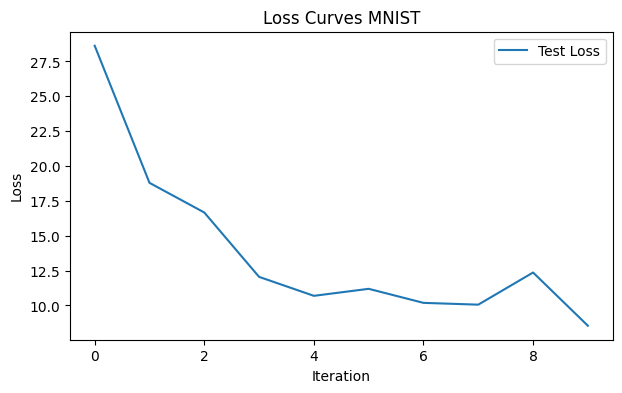

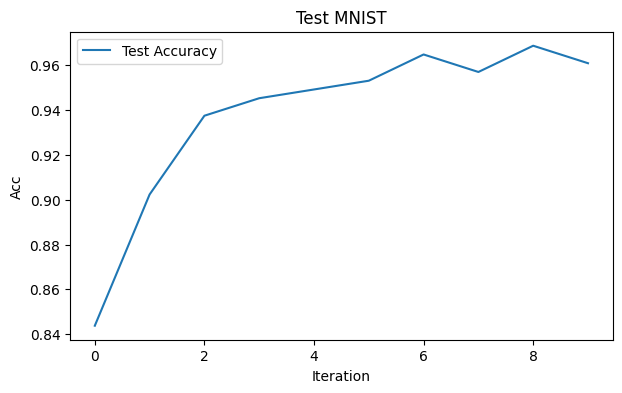

In [90]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(7, 4))
plt.plot(test_loss_hist)
plt.title("Loss Curves MNIST")
plt.legend(["Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

fig = plt.figure(facecolor="w", figsize=(7, 4))
plt.plot(acc_test_hist)
plt.title("Test MNIST")
plt.legend(["Test Accuracy"])
plt.xlabel("Iteration")
plt.ylabel("Acc")
plt.show()

# Cifar10

In [91]:
# dataloader arguments
batch_size = 64

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
mnist_test  = datasets.CIFAR10('./data', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [92]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

In [93]:
# Load the network onto CUDA if available
net = Net().to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [94]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
acc_train_hist = []
acc_test_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in tqdm(train_batch) :
        data, targets = data.to(device), targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        _, idx = spk_rec.sum(dim=0).max(1)
        train_acc = np.mean((targets == idx).detach().cpu().numpy())

        # initialize the loss & sum over time
        loss_train = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_train += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad() # clear previously stored gradients
        loss_train.backward() # calculate the gradients
        optimizer.step()      # weight update

        # Store loss history for future plotting
        loss_hist.append(loss_train.item())
        acc_train_hist.append(train_acc)

    # Test set
    net.eval()
    with torch.no_grad():
        for test_data, test_targets in test_loader:
            test_data, test_targets = test_data.to(device), test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))
            _, idx = test_spk.sum(dim=0).max(1)
            test_acc = np.mean((test_targets == idx).detach().cpu().numpy())

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)

        test_loss_hist.append(test_loss.item())
        acc_test_hist.append(test_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss_train.item():.4f}, Test Loss: {test_loss.item():.4f}, Train ACC: {train_acc:.4f}, Test ACC: {test_acc.item():.4f}')

100%|██████████| 781/781 [00:58<00:00, 13.42it/s]


Epoch 1/1, Train Loss: 47.3260, Test Loss: 47.6818, Train ACC: 0.2969, Test ACC: 0.3125


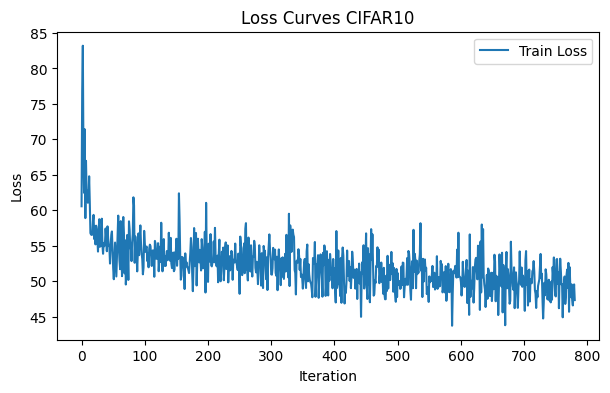

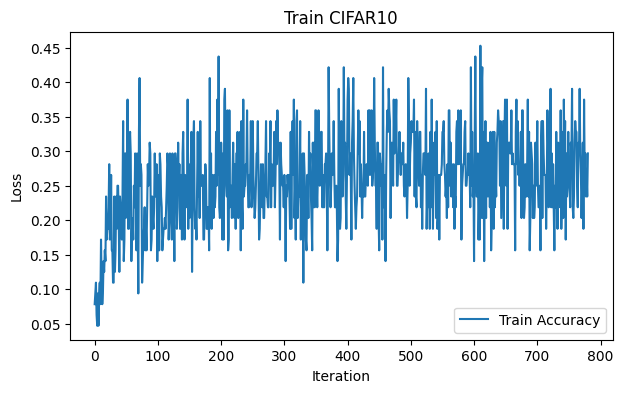

In [95]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(7, 4))
plt.plot(loss_hist)
plt.title("Loss Curves CIFAR10")
plt.legend(["Train Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# fig = plt.figure(facecolor="w", figsize=(7, 4))
# plt.plot(test_loss_hist)
# plt.title("Loss Curves CIFAR10")
# plt.legend(["Test Loss"])
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.show()

# Plot acc
fig = plt.figure(facecolor="w", figsize=(7, 4))
plt.plot(acc_train_hist)
plt.title("Train CIFAR10")
plt.legend(["Train Accuracy"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# fig = plt.figure(facecolor="w", figsize=(7, 4))
# plt.plot(acc_test_hist)
# plt.title("Test CIFAR10")
# plt.legend(["Test Accuracy"])
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.show()